# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=226e91457602e03fcd95d569a0f43092e21de51bd53f596c025701fe1fa6a924
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=3f4dd56d9126ee31788441f55368097c091d526c3a6df6ebc88170bd22287bae
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumenta

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 32.31 MiB/s, done.
Resolving deltas: 100% (3/3), done.


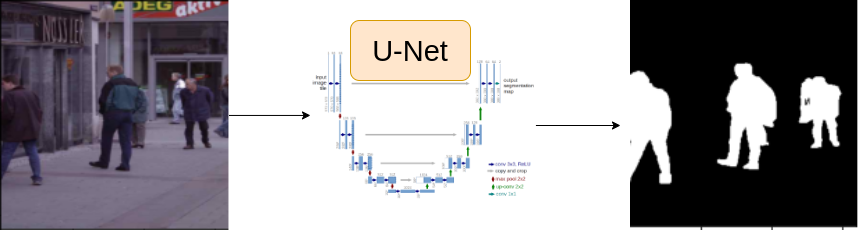

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE='/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR='/content/'

DEVICE='cuda'

EPOCHS= 25
LR=0.003
IMG_SIZE=320
BATCH_SIZE=16

ENCODER='timm-efficientnet-b0'
WEIGHTS= 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row=df.iloc[0]

image_path=row.images
mask_path=row.masks

image=cv2.imread(image_path)
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask=cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255

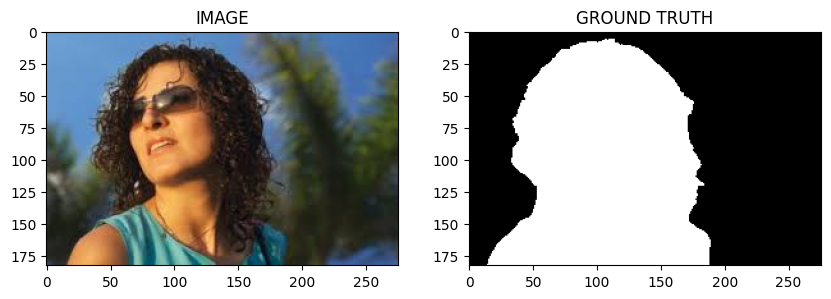

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df= train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ],
                   is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ],
  is_check_shapes=False
  )

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df=df
    self.augmentations=augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row=self.df.iloc[idx]

    image_path=row.images
    mask_path=row.masks

    image=cv2.imread(image_path)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask=cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h, w, c)
    mask=np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data=self.augmentations(image=image, mask=mask)
      image=data['image']
      mask=data['mask']

    #(h, w, c)->(c, h, w)

    image=np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask=np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image=torch.Tensor(image)/255
    mask=torch.round(torch.Tensor(mask)/255)

    return image, mask

In [ ]:
trainset= SegmentationDataset(train_df, get_train_augs())
validset= SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


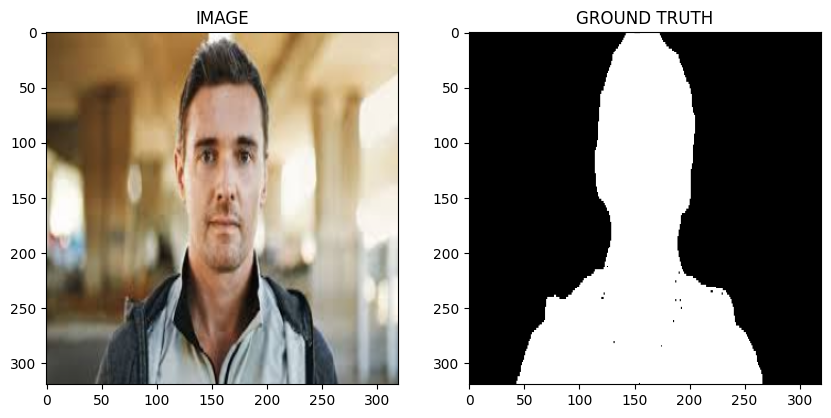

In [ ]:
idx=32

image, mask=trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader=DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader=DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 15
Total no. of batches in validloader : 4


In [ ]:
for image, mask in trainloader:
  break

print(f"One batch image shape : ", {image.shape})
print(f"One batch mask shape : ", {mask.shape})

One batch image shape :  {torch.Size([16, 3, 320, 320])}
One batch mask shape :  {torch.Size([16, 1, 320, 320])}


## Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc= smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
        )

  def forward(self, images, masks=None):
      logits=self.arc(images)

      if masks!=None:
        loss1=DiceLoss(mode="binary")(logits, masks)
        loss2=nn.BCEWithLogitsLoss()(logits, masks)
        return logits, loss1+loss2

      return logits

In [ ]:
model=SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 160MB/s]


# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss=0.0
  for images, masks in data_loader:
    images=images.to(DEVICE)
    masks=masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss=model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()

  return total_loss/len(data_loader)


In [ ]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss=0.0

  with torch.no_grad():
    for images, masks in data_loader:
      images=images.to(DEVICE)
      masks=masks.to(DEVICE)

      logits, loss=model(images, masks)

      total_loss+=loss.item()

  return total_loss/len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer=torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_valid_loss=np.Inf

for i in range(EPOCHS):
  train_loss=train_fn(trainloader, model, optimizer)
  valid_loss=eval_fn(validloader, model)

  if valid_loss< best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED MODEL")
    best_valid_loss=valid_loss
  print(f"Epoch: {i+1} Train_loss: {train_loss} Valid_loss: {valid_loss}")

SAVED MODEL
Epoch: 1 Train_loss: 0.8516018271446228 Valid_loss: 0.5699463561177254
SAVED MODEL
Epoch: 2 Train_loss: 0.3640110969543457 Valid_loss: 0.3185327649116516
Epoch: 3 Train_loss: 0.3096045196056366 Valid_loss: 0.37410980090498924
SAVED MODEL
Epoch: 4 Train_loss: 0.310407621661822 Valid_loss: 0.3148823492228985
SAVED MODEL
Epoch: 5 Train_loss: 0.2464262068271637 Valid_loss: 0.30737725645303726
SAVED MODEL
Epoch: 6 Train_loss: 0.20661952594916025 Valid_loss: 0.28201569616794586
SAVED MODEL
Epoch: 7 Train_loss: 0.2093006432056427 Valid_loss: 0.2278563603758812
Epoch: 8 Train_loss: 0.2501502275466919 Valid_loss: 0.2344691976904869
SAVED MODEL
Epoch: 9 Train_loss: 0.2412746210892995 Valid_loss: 0.2191738598048687
Epoch: 10 Train_loss: 0.2418299674987793 Valid_loss: 0.27076173946261406
SAVED MODEL
Epoch: 11 Train_loss: 0.17105016311009724 Valid_loss: 0.20749995857477188
SAVED MODEL
Epoch: 12 Train_loss: 0.16075756251811982 Valid_loss: 0.19627483934164047
SAVED MODEL
Epoch: 13 Train_l

# Task 9 : Inference

In [ ]:
idx=20

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask=validset[idx]

logits_mask=model(image.to(DEVICE).unsqueeze(0)) #(C, H, W)->(1, C, H, W)
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask>0.5)*1

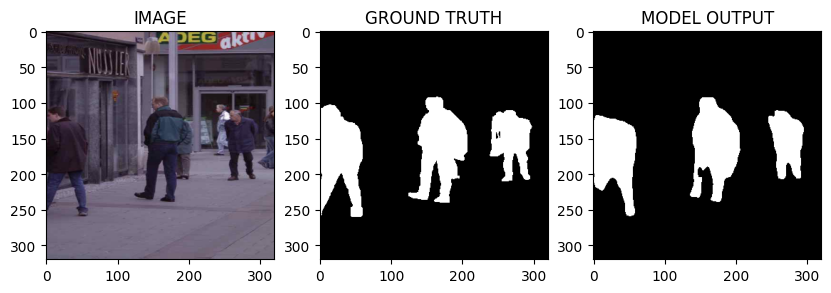

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))